In [1]:
from pathlib import Path
import polars as pl


top_n_subreddits = 1400

# === Reload anonymized data to continue using same variables ===
save_path = Path("../data/dataset/reddit_fabric/")

df_participations = pl.read_csv(save_path / "reddit_fabric_participations_anonymized.csv")
df_classes = pl.read_csv(save_path / "reddit_fabric_classes_anonymized.csv")

print("✅ Loaded anonymized DataFrames into df_participations and df_classes.")

✅ Loaded anonymized DataFrames into df_participations and df_classes.


In [ ]:
import numpy as np
import polars as pl
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as patheffects
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from openai import OpenAI
import os
import seaborn as sns

# === VISUAL STYLE ===
sns.set_context("notebook", font_scale=1.5)
plt.style.use("seaborn-white")

# === OPENAI SETUP ===
client = OpenAI(api_key="OPENAI_API_KEY")

/tmp/ipykernel_2633798/3533128439.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


/tmp/ipykernel_2633798/3135811393.py:33: RuntimeWarning: invalid value encountered in divide
  pct_attribute = np.nan_to_num(attr_weighted / total_activity, nan=0.5)
/tmp/ipykernel_2633798/3135811393.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)
/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: Fantasy Sports Discussion
Cluster 1: LGBTQ+ Issues and Discussions
Cluster 2: Numerical Activities
Cluster 3: PC Gaming Enthusiasts
Cluster 4: Adult Content
Cluster 5: UK Politics Discussion
Cluster 6: Relationship Discussions
Cluster 7: UK Discussions and Queries
Cluster 8: Firearm Commerce
Cluster 9: Anime Mobile Games
Cluster 10: Video Game Fandom
Cluster 11: Mixed Martial Arts Discussion
Cluster 12: Gift Giving Communities
Cluster 13: General Discussion and Questions
Cluster 14: Do-It-Yourself Projects
Cluster 15: Anime & Manga Culture
Cluster 16: Dungeons & Dragons Discussion
Cluster 17: Australian Football League Discussion
Cluster 18: US Politics - Pro-Trump
Cluster 19: eSports Teams Discussion


/tmp/ipykernel_2633798/3135811393.py:33: RuntimeWarning: invalid value encountered in divide
  pct_attribute = np.nan_to_num(attr_weighted / total_activity, nan=0.5)
/tmp/ipykernel_2633798/3135811393.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.
/tmp/ipykernel_2633798/3135811393.py:144: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cm.ScalarMappable(

Saved interactive data for attribute 'gender' to: ../data/output_data/embedding_data_gender.csv


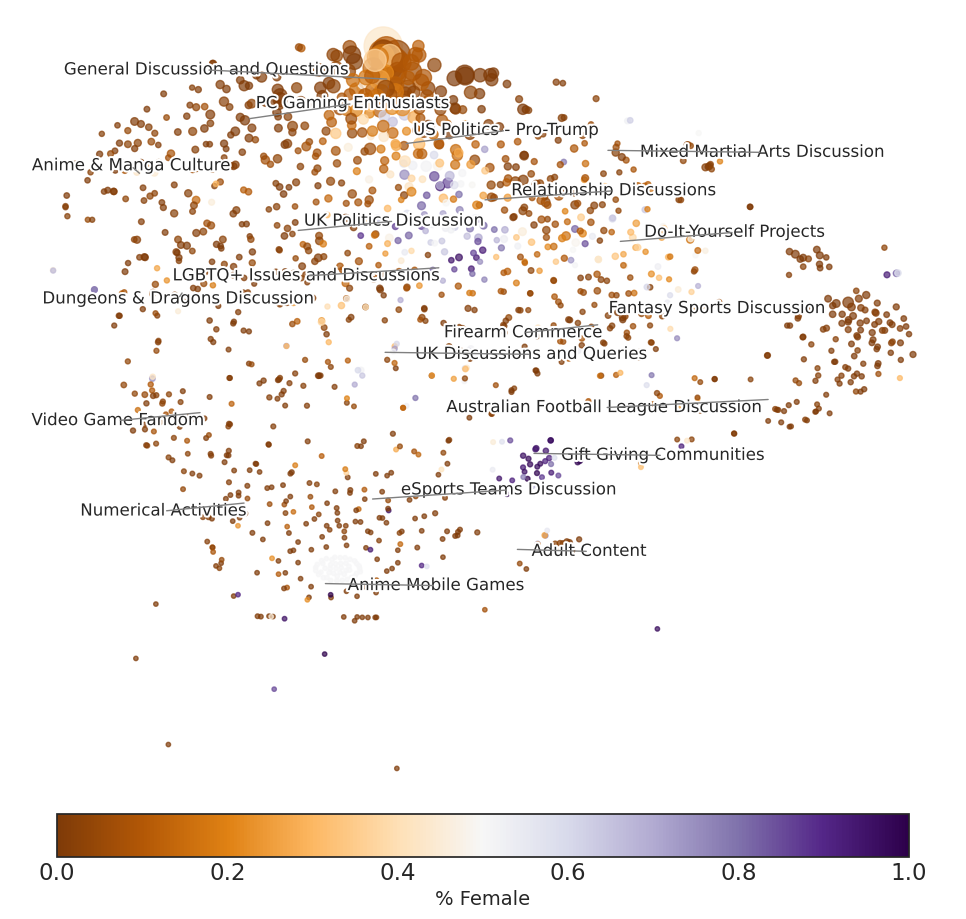

Saved interactive data for attribute 'partisan' to: ../data/output_data/embedding_data_partisan.csv


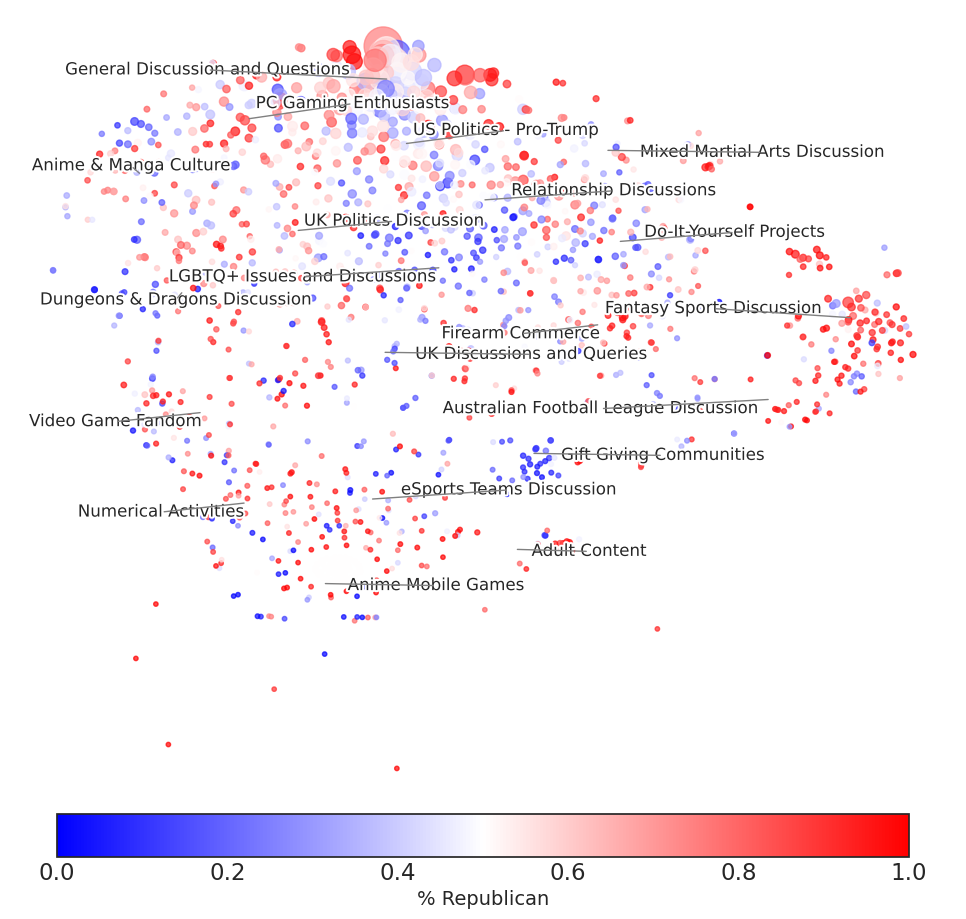

Saved interactive data for attribute 'age' to: ../data/output_data/embedding_data_age.csv


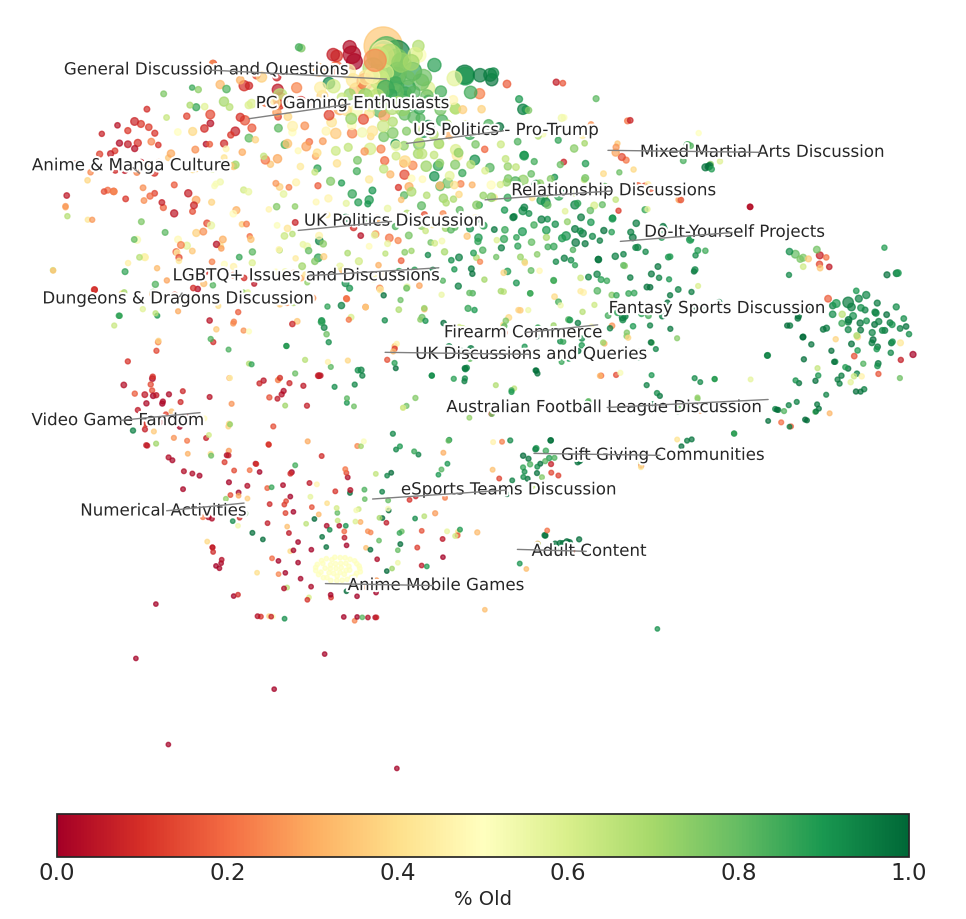

In [3]:
# === PARAMETERS ===
attributes = ["gender", "partisan", "age"]
top_n_subreddits2 = 1400
label_mode = "cluster_top_k"
top_k = 1
n_clusters = 20
naming_mode = "gpt"
save = False

# === Function: Weighted Attribute Coloring with Auto Colormap ===
def compute_weighted_attribute_colors(df_participations, df_classes, attribute, top_n_subreddits2):
    attr_lower = attribute.lower()
    if "gender" in attr_lower:
        colormap = "PuOr"
        label = "% Female"
    elif "age" in attr_lower or "year" in attr_lower:
        colormap = "RdYlGn"
        label = "% Old"
    elif "partisan" in attr_lower:
        colormap = "bwr"
        label = "% Republican"
    else:
        colormap = "viridis"
        label = f"% {attribute.title()}"

    top_subs = df_participations.columns[1:top_n_subreddits2 + 1]
    P = df_participations.select(top_subs).to_numpy().astype(np.float32)
    A = df_classes[attribute].to_numpy().astype(np.float32)

    attr_weighted = A @ P
    users = (P > 0).sum(axis=0)
    total_activity = P.sum(axis=0)
    pct_attribute = np.nan_to_num(attr_weighted / total_activity, nan=0.5)

    if  "age" in attr_lower or "year" in attr_lower:
        pct_attribute = 1 - pct_attribute

    cmap = cm.get_cmap(colormap)
    colors = [cmap(p) for p in pct_attribute]

    return colors, pct_attribute, users, top_subs, cmap, label

# === Compute PPMI Matrix ===
def compute_ppmi_matrix(cooc):
    cooc = cooc.astype(np.float64)
    total_sum = cooc.sum()
    row_sums = np.array(cooc.sum(axis=1)).flatten()
    col_sums = np.array(cooc.sum(axis=0)).flatten()
    expected = np.outer(row_sums, col_sums) / total_sum

    with np.errstate(divide='ignore', invalid='ignore'):
        ppmi = np.log2((cooc.toarray() * total_sum) / expected)
        ppmi[np.isnan(ppmi)] = 0.0
        ppmi[ppmi < 0] = 0.0
    return ppmi

# === Prepare Data ===
all_colors = {}
all_pct_values = {}
all_cmaps = {}
all_labels = {}

# Use same embedding and clusters for all
attribute = attributes[0]
colors, pct_values, activity, top_subs, cmap, colorbar_label = compute_weighted_attribute_colors(
    df_participations, df_classes, attribute, top_n_subreddits2
)

# === Define sizes ===
sizes = 750 * (activity / activity.max()) + 10

binary_matrix = (df_participations.select(top_subs).to_numpy() != 0).astype(np.uint8)
sparse_binary = csr_matrix(binary_matrix)
cooc = sparse_binary.T @ sparse_binary
ppmi_matrix = compute_ppmi_matrix(cooc)

embedding = TSNE(n_components=2, init='random', random_state=42).fit_transform(ppmi_matrix)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(embedding)

cluster_top_subs = {}
for cid in range(n_clusters):
    idx = np.where(cluster_ids == cid)[0]
    if len(idx) == 0:
        continue
    top_indices = idx[np.argsort(-activity[idx])[:top_k]]
    cluster_top_subs[cid] = [top_subs[i] for i in top_indices]

cluster_names = {}
if naming_mode == "gpt":
    for cid, subs in cluster_top_subs.items():
        prompt = (
            f"You're an expert on internet communities. "
            f"Given these subreddit names: {', '.join(subs)}, "
            f"what would you name this cluster? Give a short, descriptive label."
        )
        try:
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.7
            )
            name = response.choices[0].message.content.strip().replace('"', '').replace("'", "")
            cluster_names[cid] = name
            print(f"Cluster {cid}: {name}")
        except Exception as e:
            print(f"Error naming cluster {cid}: {e}")
            cluster_names[cid] = f"Cluster {cid}"
else:
    for cid, subs in cluster_top_subs.items():
        cluster_names[cid] = subs[0] if subs else f"Cluster {cid}"

# === Plot for each attribute ===
for attribute in attributes:
    colors, pct_values, _, _, cmap, colorbar_label = compute_weighted_attribute_colors(
        df_participations, df_classes, attribute, top_n_subreddits2
    )

    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=sizes, c=pct_values, cmap=cmap, alpha=0.7)

    texts = []
    for cid in range(n_clusters):
        idx = np.where(cluster_ids == cid)[0]
        if len(idx) == 0:
            continue
        cluster_center = embedding[idx].mean(axis=0)
        label = cluster_names.get(cid, f"Cluster {cid}")
        text = plt.text(cluster_center[0], cluster_center[1], label,
                        fontsize=12, ha='center', va='center',
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])
        texts.append(text)

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color="gray", lw=1),
        expand_text=(1.1, 1.2),
        expand_points=(1.2, 1.4),
        force_text=0.75,
    )

    norm = Normalize(vmin=0, vmax=1)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", shrink=.9, pad=0.01)
    cbar.set_label(colorbar_label, fontsize=14)

    import pandas as pd
    import os
    # === Save per-attribute data to CSV ===
    save_dir = "../data/output_data"
    os.makedirs(save_dir, exist_ok=True)

    # Rescale sizes for Bokeh
    scaled_sizes = np.clip(sizes, 5, 30)  # or: (20 * (sizes / sizes.max()) + 5)

    df_export = pd.DataFrame({
        'subreddit': top_subs,
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'orig_size': scaled_sizes,    # Save original Bokeh-scaled size
        'size': scaled_sizes,         # Initial size Bokeh will use
        'color_value': pct_values,
        'cluster_id': cluster_ids,
        'cluster_name': [cluster_names.get(cid, f"Cluster {cid}") for cid in cluster_ids]
    })

    # Save CSV for current attribute
    csv_path = os.path.join(save_dir, f"embedding_data_{attribute}.csv")
    df_export.to_csv(csv_path, index=False)
    print(f"Saved interactive data for attribute '{attribute}' to: {csv_path}")

    plt.axis('off')
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../figures/fabric-{attribute}-{top_n_subreddits}.pdf",
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1,
            format='pdf'
        )
    plt.show()



--------

In [4]:
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import to_hex

from bokeh.plotting import figure, output_file, save
from bokeh.models import (
    ColumnDataSource, HoverTool, ColorBar, LinearColorMapper,
    LabelSet, TextInput, CustomJS
)
from bokeh.layouts import row, column

# === Parameters ===
attributes = ["gender", "partisan", "age"]
colormaps = {
    "gender": "PuOr",
    "partisan": "bwr",
    "age": "RdYlGn"
}


HEIGHT, WIDTH = 500, 500
DOT_SCALE = 4


plots = []

for attribute in attributes:
    # Load CSV saved earlier for this attribute
    df = pd.read_csv(f"../data/output_data/embedding_data_{attribute}.csv")

    # Smaller point sizes
    df['size'] = df['orig_size'] / DOT_SCALE

    # === Prepare color palette using Matplotlib ===
    cmap_name = colormaps[attribute]
    mpl_cmap = cm.get_cmap(cmap_name, 256)
    palette_hex = [to_hex(mpl_cmap(i)) for i in range(256)]

    color_mapper = LinearColorMapper(palette=palette_hex, low=0, high=1)

    # === Source ===
    source = ColumnDataSource(df)

    # === Create figure ===
    attribute2label = {"gender": "Fermale", "partisan": "Republican", "age": "Old"}
    p = figure(
        title=f"{attribute.title()}",
        width=WIDTH, 
        height=HEIGHT,
        tools="pan,wheel_zoom,reset,hover",
        tooltips=[
            ("Subreddit", "@subreddit"),
            ("Cluster", "@cluster_name"),
            (f"% {attribute2label[attribute].title()}", "@color_value{0.00}")
        ]
    )

    p.circle(
        x='x', y='y',
        source=source,
        size='size',
        fill_color={'field': 'color_value', 'transform': color_mapper},
        fill_alpha=0.7,
        line_color=None
    )

    color_bar = ColorBar(color_mapper=color_mapper, location=(0, 0), title=f"% {attribute2label[attribute].title()}")
    p.add_layout(color_bar, 'below')

    # Cluster labels
    cluster_centers = df.groupby('cluster_id')[['x', 'y']].mean()
    cluster_centers['label'] = df.groupby('cluster_id')['cluster_name'].first().values
    label_source = ColumnDataSource(cluster_centers)

    labels = LabelSet(
        x='x', y='y', text='label',
        source=label_source,
        text_align='center',
        text_baseline='middle',
        text_font_size="9pt",
        background_fill_color='white',
        background_fill_alpha=0.6
    )
    p.add_layout(labels)

    # Search input per plot
    text_input = TextInput(value="", title="Search Subreddit:")

    callback = CustomJS(args=dict(source=source, text_input=text_input), code="""
        const data = source.data;
        const search = text_input.value.toLowerCase();
        for (let i = 0; i < data['subreddit'].length; i++) {
            const name = data['subreddit'][i].toLowerCase();
            const original = data['orig_size'][i];
            data['size'][i] = name.includes(search) ? Math.max(original, 20) : Math.min(original, 5);
        }
        source.change.emit();
    """)
    text_input.js_on_change('value', callback)

    plots.append(column(text_input, p))

# === Save all 3 plots side-by-side ===
output_file("../docs/fabric_interactive_all_attributes.html")
save(row(*plots))

/tmp/ipykernel_2633798/3806053346.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl_cmap = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_2633798/3806053346.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl_cmap = cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_2633798/3806053346.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl_cmap = cm.get_cmap(cmap_name, 256)


'/data/big/fcinus/submission-repos/SDI-submission/docs/fabric_interactive_all_attributes.html'